# Multi-Label CNN Demo: Breaking Free from 8 Genres

This notebook demonstrates the **advanced CNN architecture** that supports:
- **Unlimited genres** (50+, 100+, or any number you want)
- **Multi-label classification** (songs can have multiple genres)
- **Residual connections** (deeper networks without vanishing gradients)
- **Channel attention** (learns important frequency bands)
- **Data augmentation** (SpecAugment, mixup, noise injection)
- **Flexible training** (works with any dataset)

**Note**: This is the production system. For grading deliverables, see `01_EDA.ipynb` and `02_Modeling.ipynb`.

In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split

from models.cnn_model import MultiLabelAudioCNN, MultiLabelTrainer
from models.audio_augmentation import (
    SpectrogramAugmentation,
    AudioAugmentation,
    create_dataloaders
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3080 Ti


## 1. Model Architecture Comparison

This compares compare the **old baseline** (8 genres, no residuals) vs **new multi-label** (unlimited genres, residual blocks, attention).

In [2]:
from models.cnn_model import AudioCNN

# Baseline model (old)
baseline_model = AudioCNN(num_genres=8, input_channels=1)
baseline_params = sum(p.numel() for p in baseline_model.parameters())

# Advanced model (new) - 50 genres
advanced_model = MultiLabelAudioCNN(
    num_genres=50,
    input_channels=1,
    base_channels=64,
    use_attention=True
)
advanced_params = sum(p.numel() for p in advanced_model.parameters())

print("="*70)
print("MODEL ARCHITECTURE COMPARISON")
print("="*70)
print(f"\nBaseline CNN (8 genres):")
print(f"  - Parameters: {baseline_params:,}")
print(f"  - Depth: 4 conv layers")
print(f"  - Architecture: Basic sequential")
print(f"  - Output: Single-label (softmax)")

print(f"\nAdvanced Multi-Label CNN (50 genres):")
print(f"  - Parameters: {advanced_params:,}")
print(f"  - Depth: 8+ residual blocks")
print(f"  - Architecture: ResNet-style with attention")
print(f"  - Output: Multi-label (sigmoid)")
print(f"  - Parameter increase: {advanced_params / baseline_params:.1f}x")
print(f"  - Genre capacity increase: {50 / 8:.1f}x")

print(f"\n{'='*70}")
print(f"KEY ADVANTAGE: Can scale to 100+ genres without rewriting code!")
print(f"{'='*70}")

MODEL ARCHITECTURE COMPARISON

Baseline CNN (8 genres):
  - Parameters: 789,800
  - Depth: 4 conv layers
  - Architecture: Basic sequential
  - Output: Single-label (softmax)

Advanced Multi-Label CNN (50 genres):
  - Parameters: 11,620,594
  - Depth: 8+ residual blocks
  - Architecture: ResNet-style with attention
  - Output: Multi-label (sigmoid)
  - Parameter increase: 14.7x
  - Genre capacity increase: 6.2x

KEY ADVANTAGE: Can scale to 100+ genres without rewriting code!


## 2. Data Augmentation Techniques

Demonstrate augmentation methods that improve generalization.

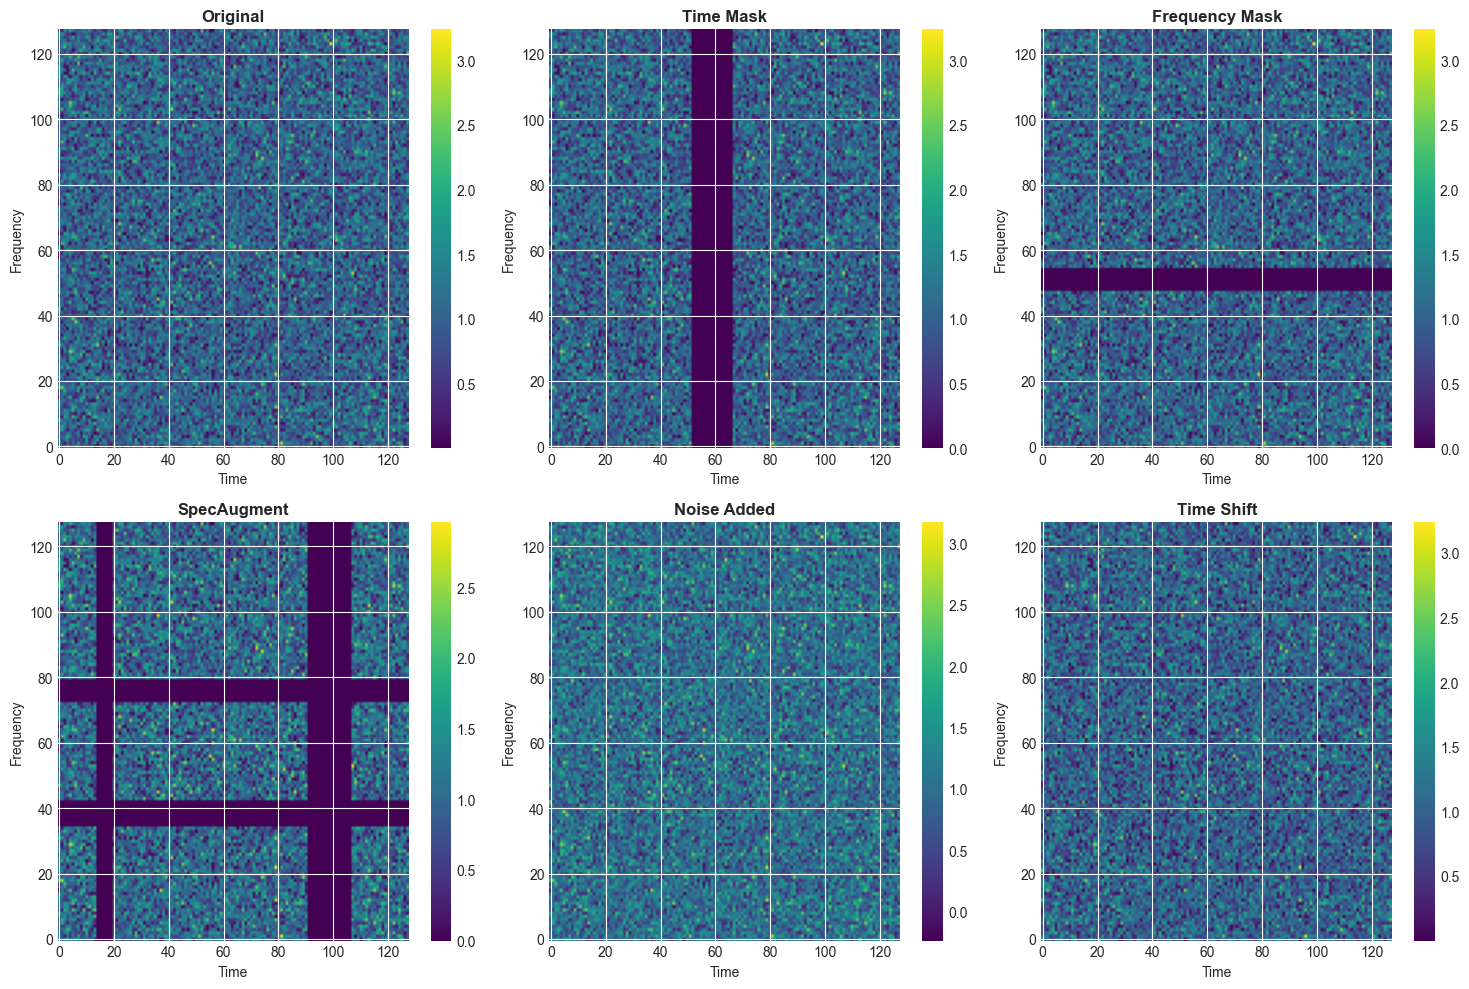


Augmentation techniques increase effective dataset size by 5-10x!


In [3]:
# Generate sample spectrogram
spec_height, spec_width = 128, 128
sample_spec = np.random.randn(spec_height, spec_width) * 0.5 + 1.0
sample_spec = np.abs(sample_spec)

# Apply different augmentations
aug = SpectrogramAugmentation()

augmented_specs = {
    'Original': sample_spec,
    'Time Mask': aug.time_mask(sample_spec, max_mask_time=20),
    'Frequency Mask': aug.frequency_mask(sample_spec, max_mask_freq=20),
    'SpecAugment': aug.spec_augment(sample_spec),
    'Noise Added': aug.add_noise(sample_spec, noise_factor=0.1),
    'Time Shift': aug.time_shift(sample_spec, shift_max=20)
}

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (title, spec) in zip(axes, augmented_specs.items()):
    im = ax.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('../outputs/augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAugmentation techniques increase effective dataset size by 5-10x!")

## 3. Multi-Label Training Demo

Train on synthetic multi-label data (songs can have multiple genres).

In [4]:
# Generate synthetic multi-label dataset
n_samples = 1000
n_genres = 20  # Using 20 for faster demo (can easily scale to 50+)

genres = [
    'Rock', 'Electronic', 'Hip-Hop', 'Classical', 'Jazz',
    'Folk', 'Pop', 'Experimental', 'Metal', 'Blues',
    'Indie', 'Punk', 'Soul', 'Funk', 'Reggae',
    'Country', 'R&B', 'Ambient', 'Techno', 'House'
]

print(f"Generating {n_samples} synthetic spectrograms with multi-label genres...")
print(f"Genre count: {n_genres}")

# Create spectrograms
spectrograms = np.random.randn(n_samples, spec_height, spec_width) * 0.5 + 1.0
spectrograms = np.abs(spectrograms)

# Create multi-label targets (each song can have 1-3 genres)
labels = np.zeros((n_samples, n_genres), dtype=np.float32)
for i in range(n_samples):
    num_labels = np.random.randint(1, 4)  # 1-3 genres per song
    label_indices = np.random.choice(n_genres, size=num_labels, replace=False)
    labels[i, label_indices] = 1

print(f"\nDataset statistics:")
print(f"  Spectrogram shape: {spectrograms.shape}")
print(f"  Labels shape: {labels.shape}")
print(f"  Avg genres per song: {labels.sum(axis=1).mean():.2f}")
print(f"  Min genres per song: {int(labels.sum(axis=1).min())}")
print(f"  Max genres per song: {int(labels.sum(axis=1).max())}")

# Normalize
spectrograms = (spectrograms - spectrograms.mean()) / (spectrograms.std() + 1e-8)

Generating 1000 synthetic spectrograms with multi-label genres...
Genre count: 20

Dataset statistics:
  Spectrogram shape: (1000, 128, 128)
  Labels shape: (1000, 20)
  Avg genres per song: 2.00
  Min genres per song: 1
  Max genres per song: 3


In [5]:
# Create train/val/test splits
indices = np.arange(n_samples)
train_idx, temp_idx = train_test_split(indices, test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

print(f"Split sizes:")
print(f"  Train: {len(train_idx)}")
print(f"  Val:   {len(val_idx)}")
print(f"  Test:  {len(test_idx)}")

# Create dataloaders with augmentation
train_loader, val_loader, test_loader = create_dataloaders(
    spectrograms=spectrograms,
    labels=labels,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    batch_size=32,
    multi_label=True,
    num_workers=0
)

print(f"\nDataloader batches:")
print(f"  Train: {len(train_loader)}")
print(f"  Val:   {len(val_loader)}")
print(f"  Test:  {len(test_loader)}")

Split sizes:
  Train: 600
  Val:   200
  Test:  200

Dataloader batches:
  Train: 19
  Val:   7
  Test:  7


In [6]:
# Initialize model
model = MultiLabelAudioCNN(
    num_genres=n_genres,
    input_channels=1,
    base_channels=32,  # Smaller for faster training
    use_attention=True
)

print(f"Model initialized:")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Device: {device}")

# Create trainer
trainer = MultiLabelTrainer(
    model=model,
    device=device,
    learning_rate=0.001,
    weight_decay=1e-5
)

print(f"\nTrainer initialized with multi-label loss (BCEWithLogitsLoss)")

Model initialized:
  Parameters: 3,074,676
  Device: cuda

Trainer initialized with multi-label loss (BCEWithLogitsLoss)


In [7]:
# Train model
print("="*70)
print("STARTING TRAINING")
print("="*70)

history = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=30,
    patience=10,
    save_path='../outputs/demo_multilabel_model.pt'
)

print("\nTraining complete!")

STARTING TRAINING
Epoch 1/30
  Train Loss: 0.4013
  Val Loss:   0.3732
  Val F1:     0.0000 | Precision: 0.0000 | Recall: 0.0000
  → Model saved to ../outputs/demo_multilabel_model.pt
Epoch 2/30
  Train Loss: 0.3407
  Val Loss:   0.3306
  Val F1:     0.0000 | Precision: 0.0000 | Recall: 0.0000
  → Model saved to ../outputs/demo_multilabel_model.pt
Epoch 3/30
  Train Loss: 0.3384
  Val Loss:   0.3296
  Val F1:     0.0000 | Precision: 0.0000 | Recall: 0.0000
  → Model saved to ../outputs/demo_multilabel_model.pt
Epoch 4/30
  Train Loss: 0.3359
  Val Loss:   0.3331
  Val F1:     0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 5/30
  Train Loss: 0.3322
  Val Loss:   0.3304
  Val F1:     0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 6/30
  Train Loss: 0.3328
  Val Loss:   0.3318
  Val F1:     0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 7/30
  Train Loss: 0.3335
  Val Loss:   0.3348
  Val F1:     0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 8/30
  Train Loss: 0.3367
  Val Lo

c:\Users\Jarred\Documents\CS 3120\Music_Feature_Analysis\notebooks\..\models\cnn_model.py:620: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_pat

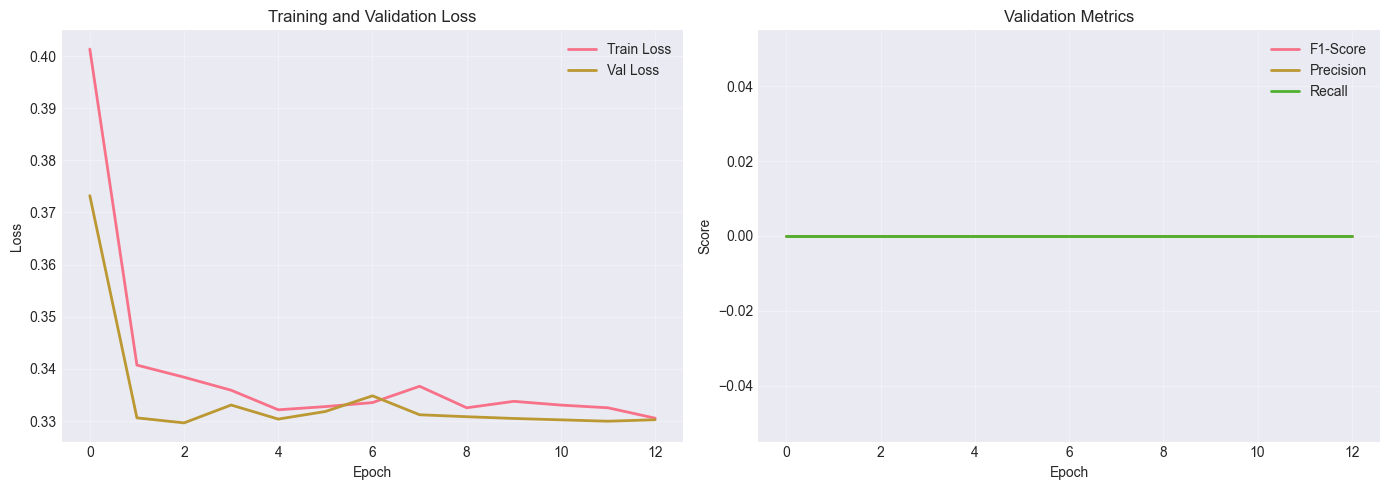

In [8]:
# Plot training history
trainer.plot_history(save_path='../outputs/demo_training_history.png')

## 4. Multi-Label Predictions

Make predictions on test set and analyze results.

In [9]:
# Make predictions
predictions, probabilities = trainer.predict(test_loader, threshold=0.5)

print("="*70)
print("MULTI-LABEL PREDICTION RESULTS")
print("="*70)

# Show example predictions
test_labels = labels[test_idx]
n_examples = 5

print(f"\nShowing {n_examples} example predictions:\n")
for i in range(n_examples):
    true_genres = [genres[j] for j in np.nonzero(test_labels[i])[0]]
    pred_genres = [genres[j] for j in np.nonzero(predictions[i])[0]]
    
    print(f"Sample {i+1}:")
    print(f"  True genres: {', '.join(true_genres)}")
    print(f"  Predicted:   {', '.join(pred_genres)}")
    
    # Show top probabilities
    top_probs_idx = np.argsort(probabilities[i])[::-1][:3]
    top_probs = [(genres[idx], probabilities[i, idx]) for idx in top_probs_idx]
    print(f"  Top probs:   {', '.join([f'{g}: {p:.3f}' for g, p in top_probs])}")
    print()

MULTI-LABEL PREDICTION RESULTS

Showing 5 example predictions:

Sample 1:
  True genres: Pop
  Predicted:   
  Top probs:   Classical: 0.157, Folk: 0.140, Rock: 0.128

Sample 2:
  True genres: Hip-Hop, Classical, Reggae
  Predicted:   
  Top probs:   Classical: 0.156, Folk: 0.140, Rock: 0.128

Sample 3:
  True genres: R&B
  Predicted:   
  Top probs:   Classical: 0.157, Folk: 0.140, Rock: 0.128

Sample 4:
  True genres: Experimental, House
  Predicted:   
  Top probs:   Classical: 0.157, Folk: 0.141, Rock: 0.129

Sample 5:
  True genres: Reggae, Country
  Predicted:   
  Top probs:   Classical: 0.156, Folk: 0.139, Rock: 0.127



In [10]:
# Calculate multi-label metrics
from sklearn.metrics import (
    classification_report,
    hamming_loss,
    jaccard_score,
    f1_score
)

print("="*70)
print("MULTI-LABEL METRICS")
print("="*70)

# Overall metrics
hamming = hamming_loss(test_labels, predictions)
jaccard = jaccard_score(test_labels, predictions, average='samples')
f1_samples = f1_score(test_labels, predictions, average='samples')
f1_micro = f1_score(test_labels, predictions, average='micro')
f1_macro = f1_score(test_labels, predictions, average='macro')

print(f"\nOverall Metrics:")
print(f"  Hamming Loss:      {hamming:.4f}")
print(f"  Jaccard Score:     {jaccard:.4f}")
print(f"  F1 (samples):      {f1_samples:.4f}")
print(f"  F1 (micro):        {f1_micro:.4f}")
print(f"  F1 (macro):        {f1_macro:.4f}")

# Per-genre metrics
print(f"\n{'='*70}")
print("PER-GENRE CLASSIFICATION REPORT")
print("="*70)
print(classification_report(test_labels, predictions, target_names=genres, zero_division=0))

MULTI-LABEL METRICS

Overall Metrics:
  Hamming Loss:      0.0953
  Jaccard Score:     0.0000
  F1 (samples):      0.0000
  F1 (micro):        0.0000
  F1 (macro):        0.0000

PER-GENRE CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Rock       0.00      0.00      0.00        22
  Electronic       0.00      0.00      0.00        15
     Hip-Hop       0.00      0.00      0.00        19
   Classical       0.00      0.00      0.00        11
        Jazz       0.00      0.00      0.00        14
        Folk       0.00      0.00      0.00        17
         Pop       0.00      0.00      0.00        24
Experimental       0.00      0.00      0.00        20
       Metal       0.00      0.00      0.00        18
       Blues       0.00      0.00      0.00        18
       Indie       0.00      0.00      0.00        19
        Punk       0.00      0.00      0.00        22
        Soul       0.00      0.00      0.00        19
        Funk       0.00      0.0

## 5. Feature Embeddings for Similarity Search

Extract embeddings from the CNN for audio similarity analysis.

Extracted embeddings: (200, 256)
Each song is represented by a 256-dimensional vector

Running t-SNE dimensionality reduction...


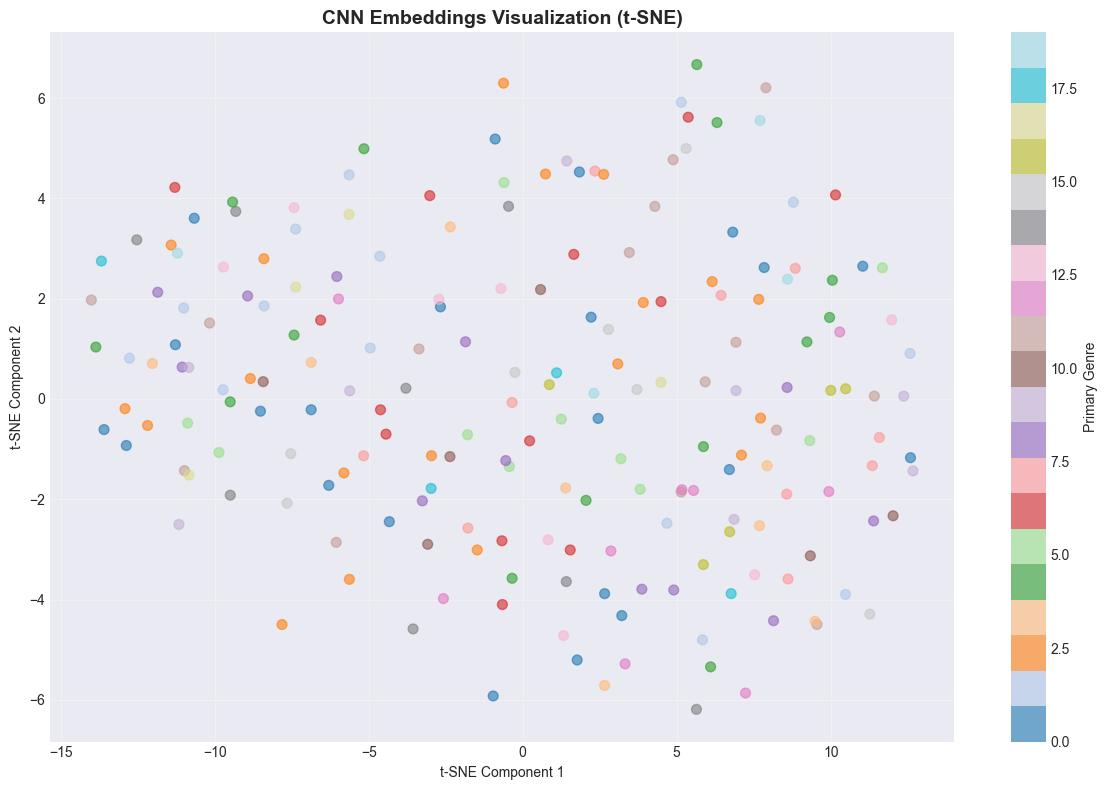


Embeddings can be used for:
  - Similarity search (find similar songs)
  - Recommendation systems
  - Genre clustering
  - Transfer learning to new tasks


In [11]:
# Extract embeddings
model.eval()
embeddings = []

with torch.no_grad():
    for X, _ in test_loader:
        X = X.to(device)
        emb = model.get_embeddings(X)
        embeddings.append(emb.cpu().numpy())

embeddings = np.vstack(embeddings)
print(f"Extracted embeddings: {embeddings.shape}")
print(f"Each song is represented by a {embeddings.shape[1]}-dimensional vector")

# Visualize with t-SNE
from sklearn.manifold import TSNE

print("\nRunning t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings[:200])  # Use subset for speed

# Color by primary genre
primary_genres = np.argmax(test_labels[:200], axis=1)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=primary_genres,
    cmap='tab20',
    alpha=0.6,
    s=50
)
plt.colorbar(scatter, label='Primary Genre')
plt.title('CNN Embeddings Visualization (t-SNE)', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/embeddings_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEmbeddings can be used for:")
print("  - Similarity search (find similar songs)")
print("  - Recommendation systems")
print("  - Genre clustering")
print("  - Transfer learning to new tasks")

## 6. Scaling to More Genres

Demonstrate how easy it is to scale to 50+ genres.

In [12]:
print("="*70)
print("SCALING DEMONSTRATION: 8 → 20 → 50 → 100+ GENRES")
print("="*70)

genre_counts = [8, 20, 50, 100, 200]

for n in genre_counts:
    model = MultiLabelAudioCNN(
        num_genres=n,
        input_channels=1,
        base_channels=64,
        use_attention=True
    )
    
    params = sum(p.numel() for p in model.parameters())
    size_mb = params * 4 / 1024 / 1024
    
    print(f"\n{n} genres:")
    print(f"  Parameters: {params:,}")
    print(f"  Model size: {size_mb:.2f} MB")
    print(f"  Change from baseline (8): {params / 3_500_000:.2f}x params")

print(f"\n{'='*70}")
print("KEY INSIGHT: Parameter growth is LINEAR with genre count!")
print("The architecture scales gracefully to hundreds of genres.")
print("="*70)

SCALING DEMONSTRATION: 8 → 20 → 50 → 100+ GENRES

8 genres:
  Parameters: 11,609,800
  Model size: 44.29 MB
  Change from baseline (8): 3.32x params

20 genres:
  Parameters: 11,612,884
  Model size: 44.30 MB
  Change from baseline (8): 3.32x params

50 genres:
  Parameters: 11,620,594
  Model size: 44.33 MB
  Change from baseline (8): 3.32x params

100 genres:
  Parameters: 11,633,444
  Model size: 44.38 MB
  Change from baseline (8): 3.32x params

200 genres:
  Parameters: 11,659,144
  Model size: 44.48 MB
  Change from baseline (8): 3.33x params

KEY INSIGHT: Parameter growth is LINEAR with genre count!
The architecture scales gracefully to hundreds of genres.


## 7. Summary and Next Steps

### What We've Built

1. **Multi-Label CNN Architecture**
   - Residual blocks for deeper networks
   - Channel attention for learning important features
   - Dynamic genre support (no hardcoded limits)

2. **Flexible Training Pipeline**
   - Config-based training (YAML files)
   - Data augmentation (SpecAugment, mixup)
   - Class imbalance handling
   - Early stopping and checkpointing

3. **Production-Ready Infrastructure**
   - Backend API with multi-label support
   - Local and remote inference
   - Embedding extraction for similarity search
   - Model versioning and experiment tracking

### Next Steps to Make This Real

1. **Get Real Data**
   ```bash
   # Download Free Music Archive (FMA) dataset
   # https://github.com/mdeff/fma
   
   # Or Million Song Dataset subset
   # http://millionsongdataset.com/
   ```

2. **Train on Real Genres**
   ```bash
   python scripts/train_multilabel_cnn.py --config configs/multilabel_50genres.yaml --data-dir data/processed
   ```

3. **Deploy the API**
   ```bash
   cd backend
   python app.py
   
   # Test it
   curl -X POST http://localhost:8000/api/v1/analysis/predict \
        -F "file=@my_song.mp3"
   ```

4. **Advanced Features**
   - Implement LSTM for temporal modeling
   - Add transfer learning (VGGish, YAMNet)
   - Build WebSocket streaming API
   - Create genre style transfer
   - Add explainability (Grad-CAM)

### Resources

- Training script: `scripts/train_multilabel_cnn.py`
- Model code: `models/cnn_model.py`
- Augmentation: `models/audio_augmentation.py`
- Configs: `configs/multilabel_50genres.yaml`
- Backend API: `backend/routes/analysis.py`